In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gplately
from gplately import pygplates
from scipy import ndimage
from scipy.spatial import cKDTree
from joblib import Parallel, delayed
import pandas as pd

# agegrid_dir = "/Users/ben/Dropbox/USyd/GPlates/SampleData/Rasters/M2020_AgeGrids/"
# agegrid_filename = agegrid_dir + "Muller_etal_2019_Tectonics_v2.0_AgeGrid-{:.0f}.nc"

agegrid_dir = "/Users/ben/Dropbox/USyd/GPlates/"
agegrid_filename = agegrid_dir+"slab_dip/Clennet_AgeGrids_0.1d_masked/seafloor_age_mask_{:.1f}Ma.nc"

reconstruction_times = np.arange(0,171)

In [2]:
# Call GPlately's DataServer from the download.py module
gdownload = gplately.download.DataServer("Matthews2016")

# Obtain all rotation files, topology features and static polygons from Muller et al. 2019
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [3]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object
time = 0 #Ma
gplot = gplately.PlotTopologies(model, coastlines, continents, COBs, time=time)

Checking whether the requested files need to be updated...
Requested files are up-to-date!
No continent-ocean boundaries in Matthews2016.


In [4]:
seamounts_filename = "data/Pacific_synthetic_seamounts.gpml"
seamounts = pygplates.FeatureCollection(seamounts_filename)


## Import present-day plume locations

In [5]:
plume_data = pd.read_excel("data/Whittaker2015_tableS2.xlsx", skiprows=1)
plume_lon = plume_data['Long']
plume_lat = plume_data['Lat']

/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### Construct motion paths

In [26]:
plume_pts = gplately.Points(model, plume_lon, plume_lat)
seamount_chain_lon, seamount_chain_lat = plume_pts.motion_path(reconstruction_times, anchor_plate_id=2)

In [50]:
def motion_path(self, time_array, anchor_plate_id=0, return_rate_of_motion=False):
    """ Create a path of points to mark the trajectory of a plate's motion 
    through geological time.

    Parameters
    ----------
    time_array : arr
        An array of reconstruction times at which to determine the trajectory 
        of a point on a plate. For example:

            import numpy as np
            min_time = 30
            max_time = 100
            time_step = 2.5
            time_array = np.arange(min_time, max_time + time_step, time_step)

    anchor_plate_id : int, default=0
        The ID of the anchor plate.
    return_rate_of_motion : bool, default=False
        Choose whether to return the rate of plate motion through time for each

    Returns
    -------
    rlons : ndarray
        An n-dimensional array with columns containing the longitudes of 
        the seed points at each timestep in `time_array`. There are n 
        columns for n seed points. 
    rlats : ndarray
        An n-dimensional array with columns containing the latitudes of 
        the seed points at each timestep in `time_array`. There are n 
        columns for n seed points. 
    """
    time_array = np.atleast_1d(time_array)

    # ndarrays to fill with reconstructed points and 
    # rates of motion (if requested)
    rlons = np.zeros((len(time_array),   len(self.lons)))
    rlats = np.zeros((len(time_array),   len(self.lons)))
    StepTimes = np.empty(((len(time_array)-1)*2, len(self.lons)))
    StepRates = np.empty(((len(time_array)-1)*2, len(self.lons)))

    seed_points = list(zip(self.lats, self.lons))
    for i, lat_lon in enumerate(seed_points):

        seed_points_at_digitisation_time = pygplates.PointOnSphere(
            pygplates.LatLonPoint(float(lat_lon[0]), float(lat_lon[1]))
        )

        # Create the motion path feature
        motion_path_feature = pygplates.Feature.create_motion_path(
            seed_points_at_digitisation_time, 
            time_array.tolist(),
            valid_time=(time_array.max(), time_array.min()),
            #relative_plate=int(self.plate_id[i]),
            #reconstruction_plate_id=int(anchor_plate_id))
            reconstruction_plate_id=int(anchor_plate_id),
            relative_plate=int(self.plate_id[i]))

        reconstructed_motion_paths = self.plate_reconstruction.reconstruct(
            motion_path_feature, 
            to_time=0, 
            #from_time=0, 
            reconstruct_type=pygplates.ReconstructType.motion_path)

        # Turn motion paths in to lat-lon coordinates
        for reconstructed_motion_path in reconstructed_motion_paths:
            trail = reconstructed_motion_path.get_motion_path().to_lat_lon_array()

        lon, lat = np.flipud(trail[:, 1]), np.flipud(trail[:, 0])
        rlons[:len(lon),i] = lon
        rlats[:len(lat),i] = lat

    return np.squeeze(rlons), np.squeeze(rlats)

In [51]:
seamount_chain_lon, seamount_chain_lat = motion_path(plume_pts, reconstruction_times, anchor_plate_id=2)

## Compare synthetic seamounts

/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)


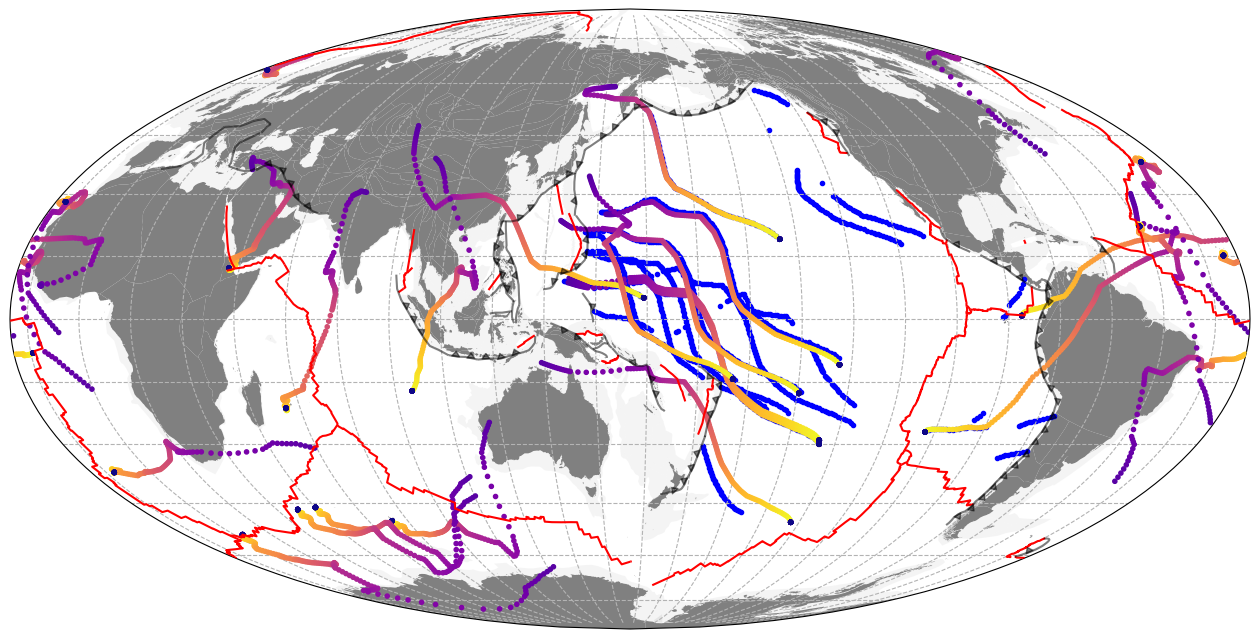

In [52]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 160))
ax.set_global()
ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))

# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = 0 # Ma
# gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
gplot.plot_continents(ax, facecolor='0.8', alpha=0.2)
gplot.plot_coastlines(ax, color='0.5')
gplot.plot_ridges_and_transforms(ax, color='red', zorder=9)

gplot.plot_feature(ax, model.reconstruct(seamounts, gplot.time), color='Blue', marker='.')
for col in range(0, seamount_chain_lon.shape[1]):
    ax.scatter(seamount_chain_lon[:,col], seamount_chain_lat[:,col],
               c=reconstruction_times, cmap='plasma_r', marker='.', transform=ccrs.PlateCarree(), zorder=3)

# ax.scatter(seamount_lons, seamount_lats, c='b', marker='.', transform=ccrs.PlateCarree())
# ax.scatter(sz_lons, sz_lats, c='yellow', transform=ccrs.PlateCarree())

gplot.plot_trenches(ax, color='k', zorder=9, alpha=0.5)
gplot.plot_subduction_teeth(ax, color='k', zorder=10, alpha=0.5)

In [23]:
def reconstruct_seamount_subduction(time, dtol=50, return_seamounts=False):
    subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.2), ignore_warnings=True)
    trench_lons = subduction_data[:,0]
    trench_lats = subduction_data[:,1]
    trench_norm = subduction_data[:,7]
    
    # reconstruct seamount and extract points on sphere
    reconstructed_seamounts = model.reconstruct(seamounts_filename, time)
    seamount_lons = np.zeros(len(reconstructed_seamounts))
    seamount_lats = np.zeros(len(reconstructed_seamounts))
    for i, seamount in enumerate(reconstructed_seamounts):
        seamount_lats[i], seamount_lons[i] = seamount.get_reconstructed_geometry().to_lat_lon()
    
    # find the nearest trench segment for each seamount
    xt, yt, zt = gplately.tools.lonlat2xyz(trench_lons, trench_lats)
    xs, ys, zs = gplately.tools.lonlat2xyz(seamount_lons, seamount_lats)
    tree_seamount = cKDTree(np.c_[xs,ys,zs])
    dist_to_seamount, idx_seamount = tree_seamount.query(np.c_[xt, yt, zt])
    dist_to_seamount *= gplately.EARTH_RADIUS
    
    # filter trench segments within dtol of each seamount
    mask_trench_seamount = dist_to_seamount <= dtol
    sz_lons = trench_lons[mask_trench_seamount]
    sz_lats = trench_lats[mask_trench_seamount]
    
#     # remove duplicate entries
#     sz_coords = np.c_[sz_lons, sz_lats]
#     unique_sz_coords = np.unique(sz_coords, axis=1)
#     print(unique_sz_coords.shape, sz_coords.shape)
    
    if return_seamounts:
        return seamount_lons, seamount_lats, sz_lons, sz_lats
    else:
        return trench_lons[mask_trench_seamount], trench_lats[mask_trench_seamount]

In [24]:
seamount_lons, seamount_lats, sz_lons, sz_lats = reconstruct_seamount_subduction(0, return_seamounts=True)

/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)


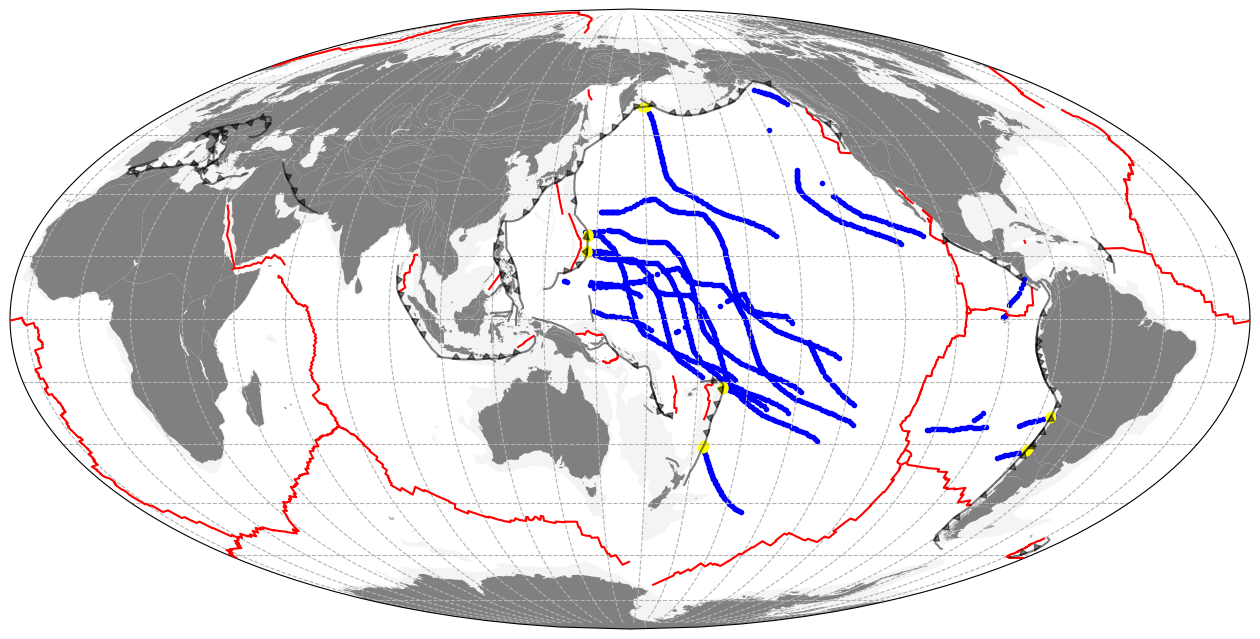

In [ ]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 160))
ax.set_global()
ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))


# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = time # Ma
# gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
gplot.plot_continents(ax, facecolor='0.8', alpha=0.2)
gplot.plot_coastlines(ax, color='0.5')
gplot.plot_ridges_and_transforms(ax, color='red', zorder=9)

ax.scatter(seamount_lons, seamount_lats, c='b', marker='.', transform=ccrs.PlateCarree())
ax.scatter(sz_lons, sz_lats, c='yellow', transform=ccrs.PlateCarree())

gplot.plot_trenches(ax, color='k', zorder=9, alpha=0.5)
gplot.plot_subduction_teeth(ax, color='k', zorder=10, alpha=0.5)


In [16]:
# Use LokyBackend to protect the netCDF routine
sz_data = Parallel(n_jobs=-3, backend='loky', verbose=1)\
(delayed(reconstruct_seamount_subduction) (time,) for time in reconstruction_times)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   23.8s
/Users/ben/miniforge3/envs/pygplates/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-3)]: Done 171 out of 171 | elapsed:  1.7min finished


In [18]:
sz_data_dict = dict()

for i, time in enumerate(reconstruction_times):
    sz_data_dict[str(time)] = sz_data[i]
    
np.savez_compressed('subducted_synthetic_seamount_data.npz', **sz_data_dict)